In [7]:
from IPython import display
from pathlib import Path
import shutil
import yaml

display.clear_output()

# Load config
with open('../config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Prevent ultralytics from tracking activity
!yolo settings sync=False

import ultralytics
ultralytics.checks()

Ultralytics 8.4.14 🚀 Python-3.13.11 torch-2.10.0 CPU (Apple M3 Pro)
Setup complete ✅ (11 CPUs, 36.0 GB RAM, 282.1/460.4 GB disk)


# Vision Pipeline Dataset Cleaner

**Purpose**: Clean and filter image dataset for computer vision tasks

**Pipeline Steps**:
1. Data Quality Check (CleanVision)
2. Person Detection (YOLOv8)
3. Full-body & Face Validation
4. Age/Gender Filtering
5. Advertisement Removal

---
# Phase 1: Dataset cleaning with CleanVision

In [8]:
from ultralytics import YOLO
from IPython.display import display, Image
from cleanvision import Imagelab
from tqdm import tqdm

### Check dataset

In [9]:
# Check original dataset
data_path = Path(f"../{config['paths']['original_raw']}")
image_count = len(list(data_path.rglob('*.png')))
print(f"Total images in original_raw: {image_count}")

Total images in original_raw: 1147


### Clean dataset 
- did not remove odd aspect ratio because some images in the input dataset is already cropped
- source: https://github.com/cleanlab/cleanvision
- Future development: Create your own issue type by extending base class `IssueManager`.

Reading images from /Users/carlychinsekyi/Downloads/GitHub/vision-pipeline-dataset-cleaner/notebooks/../data/original_raw
Checking for exact_duplicates, near_duplicates, low_information, dark, light, blurry images ...


Computing scores: 100%|██████████| 1147/1147 [00:02<00:00, 443.36it/s]


Issue checks completed. 409 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().
Issues found in images in order of severity in the dataset

|    | issue_type       |   num_images |
|---:|:-----------------|-------------:|
|  0 | exact_duplicates |          279 |
|  1 | blurry           |           76 |
|  2 | dark             |           54 |
|  3 | near_duplicates  |            0 |
|  4 | low_information  |            0 |
|  5 | light            |            0 | 

----------------- exact_duplicates images ------------------

Number of examples with this issue: 279
Examples representing most severe instances of this issue:

Set: 0


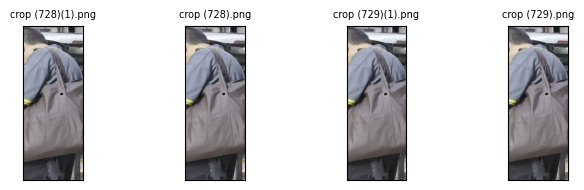

Set: 1


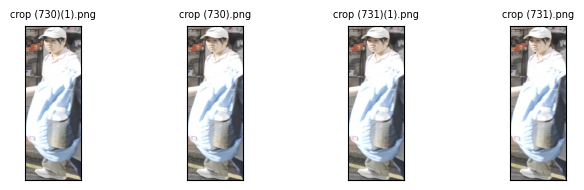

Set: 2


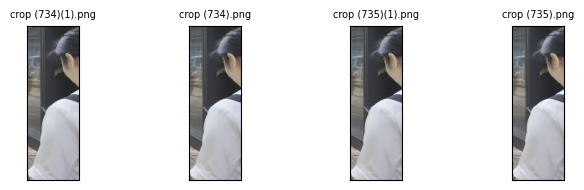

Set: 3


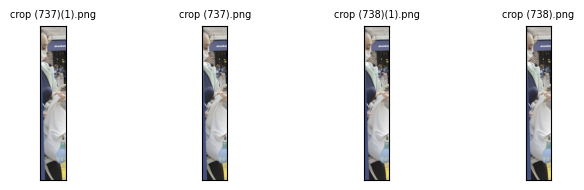

---------------------- blurry images -----------------------

Number of examples with this issue: 76
Examples representing most severe instances of this issue:



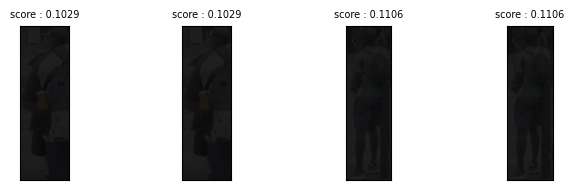

----------------------- dark images ------------------------

Number of examples with this issue: 54
Examples representing most severe instances of this issue:



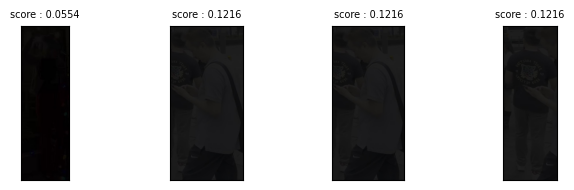

In [10]:
imagelab = Imagelab(data_path=str(data_path))

# Build issue types from config
issue_types = {issue: {} for issue in config['cleanvision']['issue_types']}

imagelab.find_issues(issue_types)
imagelab.report()

In [11]:
# Filter and copy clean images
issue_columns = [col for col in imagelab.issues.columns if col.startswith('is_') and col.endswith('_issue')]
clean_df = imagelab.issues[~imagelab.issues[issue_columns].any(axis=1)]
clean_names = set([Path(p).name for p in clean_df.index.tolist()])

# Recreate cleaned_raw directory
cleaned_data_path = Path(f"../{config['paths']['cleaned_raw']}")
if cleaned_data_path.exists():
    shutil.rmtree(cleaned_data_path)
cleaned_data_path.mkdir(exist_ok=True)

# Copy clean images only
good_images = 0
for img in sorted(data_path.glob('*.png')):
    if img.name in clean_names:
        shutil.copy(img, cleaned_data_path / img.name)
        good_images += 1

print(f"Copied {good_images} clean images to {config['paths']['cleaned_raw']}/")
print(f"Removed {len(imagelab.issues) - good_images} problematic images")

Copied 785 clean images to data/cleaned_raw/
Removed 362 problematic images


In [12]:
# Verify cleaned dataset
clean_image_count = len(list(cleaned_data_path.rglob('*.png')))
print(f"Total images in cleaned_raw: {clean_image_count}")

Total images in cleaned_raw: 785


**Note**: 
- Used default config from CleanVision. No hyperparameter tuning needed.

**TODO**:
- In modular code, skip saving cleaned dataset - pass directly to next pipeline stage
